In [27]:
# Dependencies
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import make_scorer, cohen_kappa_score, accuracy_score
pd.set_option('display.max_columns', None)

In [28]:
pet_df = pd.read_csv("../data/train/train.csv") #Beware of directory
test_df = pd.read_csv("../data/test/test.csv") 

In [29]:
def featurize_table(tabular_df):
    # Namelength
    tabular_df["name_length"] = tabular_df['Name'].str.len().fillna(0)
    
    # Description length
    tabular_df['description_length'] = tabular_df['Description'].str.len().fillna(0)
    
    # Drop unused columns
    tabular_df.drop(['Name', 'PetID', 'RescuerID', 'Description'], axis=1, inplace=True)
    return tabular_df

#categorical_features = 
#numerical_features = 
pet_features = featurize_table(pet_df)
eval_features = featurize_table(test_df)
pet_features.head()

,Type,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,VideoAmt,PhotoAmt,AdoptionSpeed,name_length,description_length
0,2,3,299,0,1,1,7,0,1,1,2,2,2,1,1,100,41326,0,1.0,2,6.0,359.0
1,2,1,265,0,1,1,2,0,2,2,3,3,3,1,1,0,41401,0,2.0,0,11.0,118.0
2,1,1,307,0,1,2,7,0,2,2,1,1,2,1,1,0,41326,0,7.0,3,6.0,393.0
3,1,4,307,0,2,1,2,0,2,1,1,1,2,1,1,150,41401,0,8.0,2,4.0,146.0
4,1,1,307,0,1,1,0,0,2,1,2,2,2,1,1,0,41326,0,3.0,2,6.0,390.0


In [ ]:
# Splitting the data from train.csv
X = pet_features.drop(['AdoptionSpeed'], axis=1)
y = pet_features['AdoptionSpeed'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
prediction_dummy = dummy_clf.predict(X_test)

# Pure XGBoost

In [32]:
# XGBoost (Basic)
xgb_clf = xgb.XGBClassifier(
    objective='clf:accuracy',
    n_estimators = 100,
    learning_rate=0.1,
    max_depth=2,
    #early_stopping_rounds=50, # Use early stoppage to mitigate overfitting
    n_jobs=-1 # enables parallel on all cores for faster training
)

xgb_clf.fit(X_train, y_train)
prediction_xgb = xgb_clf.predict(X_test)


In [42]:
# XGBoost (Tuned)
parameters = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [5, 7, 9, 12],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0]
}

rscv = RandomizedSearchCV(
    estimator=xgb.XGBClassifier(objective="multi:softprob", # softmax only return the winning class, this will return a vector we want
                                eval_metric = "mlogloss"), # validation metric for early stoppage in training
    param_distributions=parameters,
    scoring=make_scorer(cohen_kappa_score, weights='quadratic'), # Decider for best model from rscv
    n_iter=50, # Try n random combinations
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1 # Parallel processing
)

rscv.fit(X_train, y_train)
print (f"Best Parameters: {rscv.best_params_}")
print (f"Average Quadratic Weighted Kappa Score on all validation folds: {rscv.best_score_:.4f}")
xgb_bestmodel = rscv.best_estimator_
prediction_xgb_best = xgb_bestmodel.predict(X_test) # Get class prediction
probs_xgb_best = xgb_bestmodel.predict_proba(X_test) # Get probs for all classes

prediction_train = xgb_bestmodel.predict(X_train)
print(f"Real Kappa on Training Set: {cohen_kappa_score(prediction_train, y_train, weights='quadratic'):.4f}")


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'subsample': 0.7, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.05, 'colsample_bytree': 1.0}
Average Quadratic Weighted Kappa Score on all validation folds: 0.3518
Real Kappa on Training Set: 0.6649


In [ ]:
# Get the probs of each target label for train.csv -> test ensemble
probs_tabular = xgb_bestmodel.predict_proba(X)
print(probs_tabular.shape) 

probs_tabular_df = pd.DataFrame(probs_tabular)
probs_tabular_df.columns = ['label0_tabular', 'label1_tabular', "label2_tabular", "label3_tabular", "label4_tabular"]
probs_tabular_df


(14993, 5)


,A,B,C,D,D
0,0.019273,0.215292,0.290051,0.128190,0.347193
1,0.190339,0.207187,0.367293,0.111812,0.123370
2,0.006647,0.144019,0.280570,0.539726,0.029038
3,0.004370,0.041009,0.203183,0.237774,0.513664
4,0.005999,0.471432,0.274862,0.188629,0.059077
...,...,...,...,...,...
14988,0.019381,0.337081,0.253498,0.185582,0.204458
14989,0.015396,0.079449,0.189550,0.195423,0.520181
14990,0.027998,0.130930,0.132282,0.553202,0.155587
14991,0.023562,0.108299,0.241469,0.300034,0.326636


# Evaluate

In [46]:
from sklearn.metrics import cohen_kappa_score, accuracy_score

def evaluate_model(model, model_prediction):
    print(f"Model: {model.__class__.__name__}")
    print(f"Kappa Score: {cohen_kappa_score(model_prediction, y_test, weights='quadratic'):.4f}")
    print(f"Accuracy Score: {accuracy_score(model_prediction, y_test):.4f}")
    

evaluate_model(dummy_clf, prediction_dummy) # Kappa should be 0 bcuz it's random
print(f"Unique predictions by Dummy Classifier: {np.unique(prediction_dummy)}")
print ("")
print ("- Basic XGBoost Classifier")
evaluate_model(xgb_clf, prediction_xgb)

print ("- Tuned XGBoost Classifier- ")
evaluate_model(xgb_bestmodel, prediction_xgb_best)

Model: DummyClassifier
Kappa Score: 0.0000
Accuracy Score: 0.2778
Unique predictions by Dummy Classifier: [4]

- Basic XGBoost Classifier
Model: XGBClassifier
Kappa Score: 0.3606
Accuracy Score: 0.4075
- Tuned XGBoost Classifier- 
Model: XGBClassifier
Kappa Score: 0.3914
Accuracy Score: 0.4308


<Figure size 1200x600 with 0 Axes>

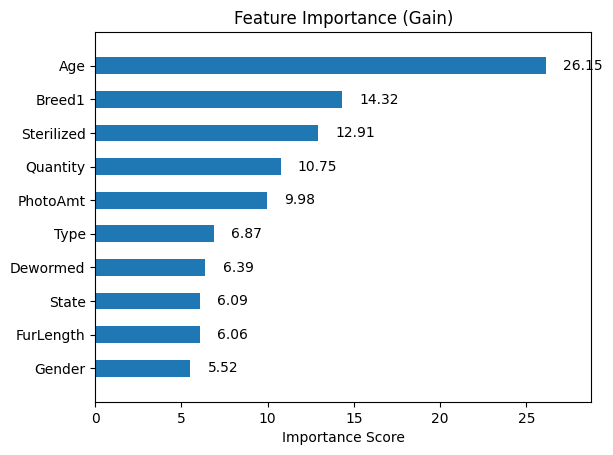

In [35]:
# Feature Importance: which factors benefit the prediction the most (extracted from XGBoost)
# ensure usage of original feature names not just np array indices
xgb_clf.get_booster().feature_names = list(X.columns)

plt.figure(figsize=(12,6))
xgb.plot_importance(xgb_clf, max_num_features=10, height=0.5, importance_type="gain", values_format = "{v:.2f}") # Weight ใช้อะไรมากที่สุดเป็นส่วนประกอบ tree, Gain อะไรแบ่งได้มากสุด
plt.title("Feature Importance (Gain)")
plt.xlabel("Importance Score")
plt.ylabel("")
plt.grid(False)
plt.show()